<a href="https://colab.research.google.com/github/yvette333777/housing-price-decision-analysis/blob/main/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E6%9C%9F%E6%9C%AB%E4%BD%9C%E6%A5%AD_26%E8%99%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

載入資料

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing()
df = pd.DataFrame(housing.data ,columns=housing.feature_names)
df['MedHouseVal'] = housing.target
print(df.head())

#California Housing 資料集包含 20639 個人口普查區
#MedInc（中位數收入）、HouseAge（中位數住房年齡）、AveRooms（平均房間數目）、AveBedrms（平均臥室數目）、Population（該區人口普查的人口數）、
#AveOccup（平均住房占用率）、Latitude（緯度）、Longitude（經度）、MedHouseVal(中位房價)

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


特徵工程

In [ ]:
import numpy as np

df['SpacePerCapita'] = df['AveRooms'] / df['AveOccup']

SF_COORD = (37.7749, -122.4194)
LA_COORD = (34.0522, -118.2437)
df['Dist_to_SF'] = np.sqrt((df['Latitude'] - SF_COORD[0])**2 + (df['Longitude'] - SF_COORD[1])**2)
df['Dist_to_LA'] = np.sqrt((df['Latitude'] - LA_COORD[0])**2 + (df['Longitude'] - LA_COORD[1])**2)

df_filtered = df[df['MedHouseVal'] < 4.9]

散點圖矩陣

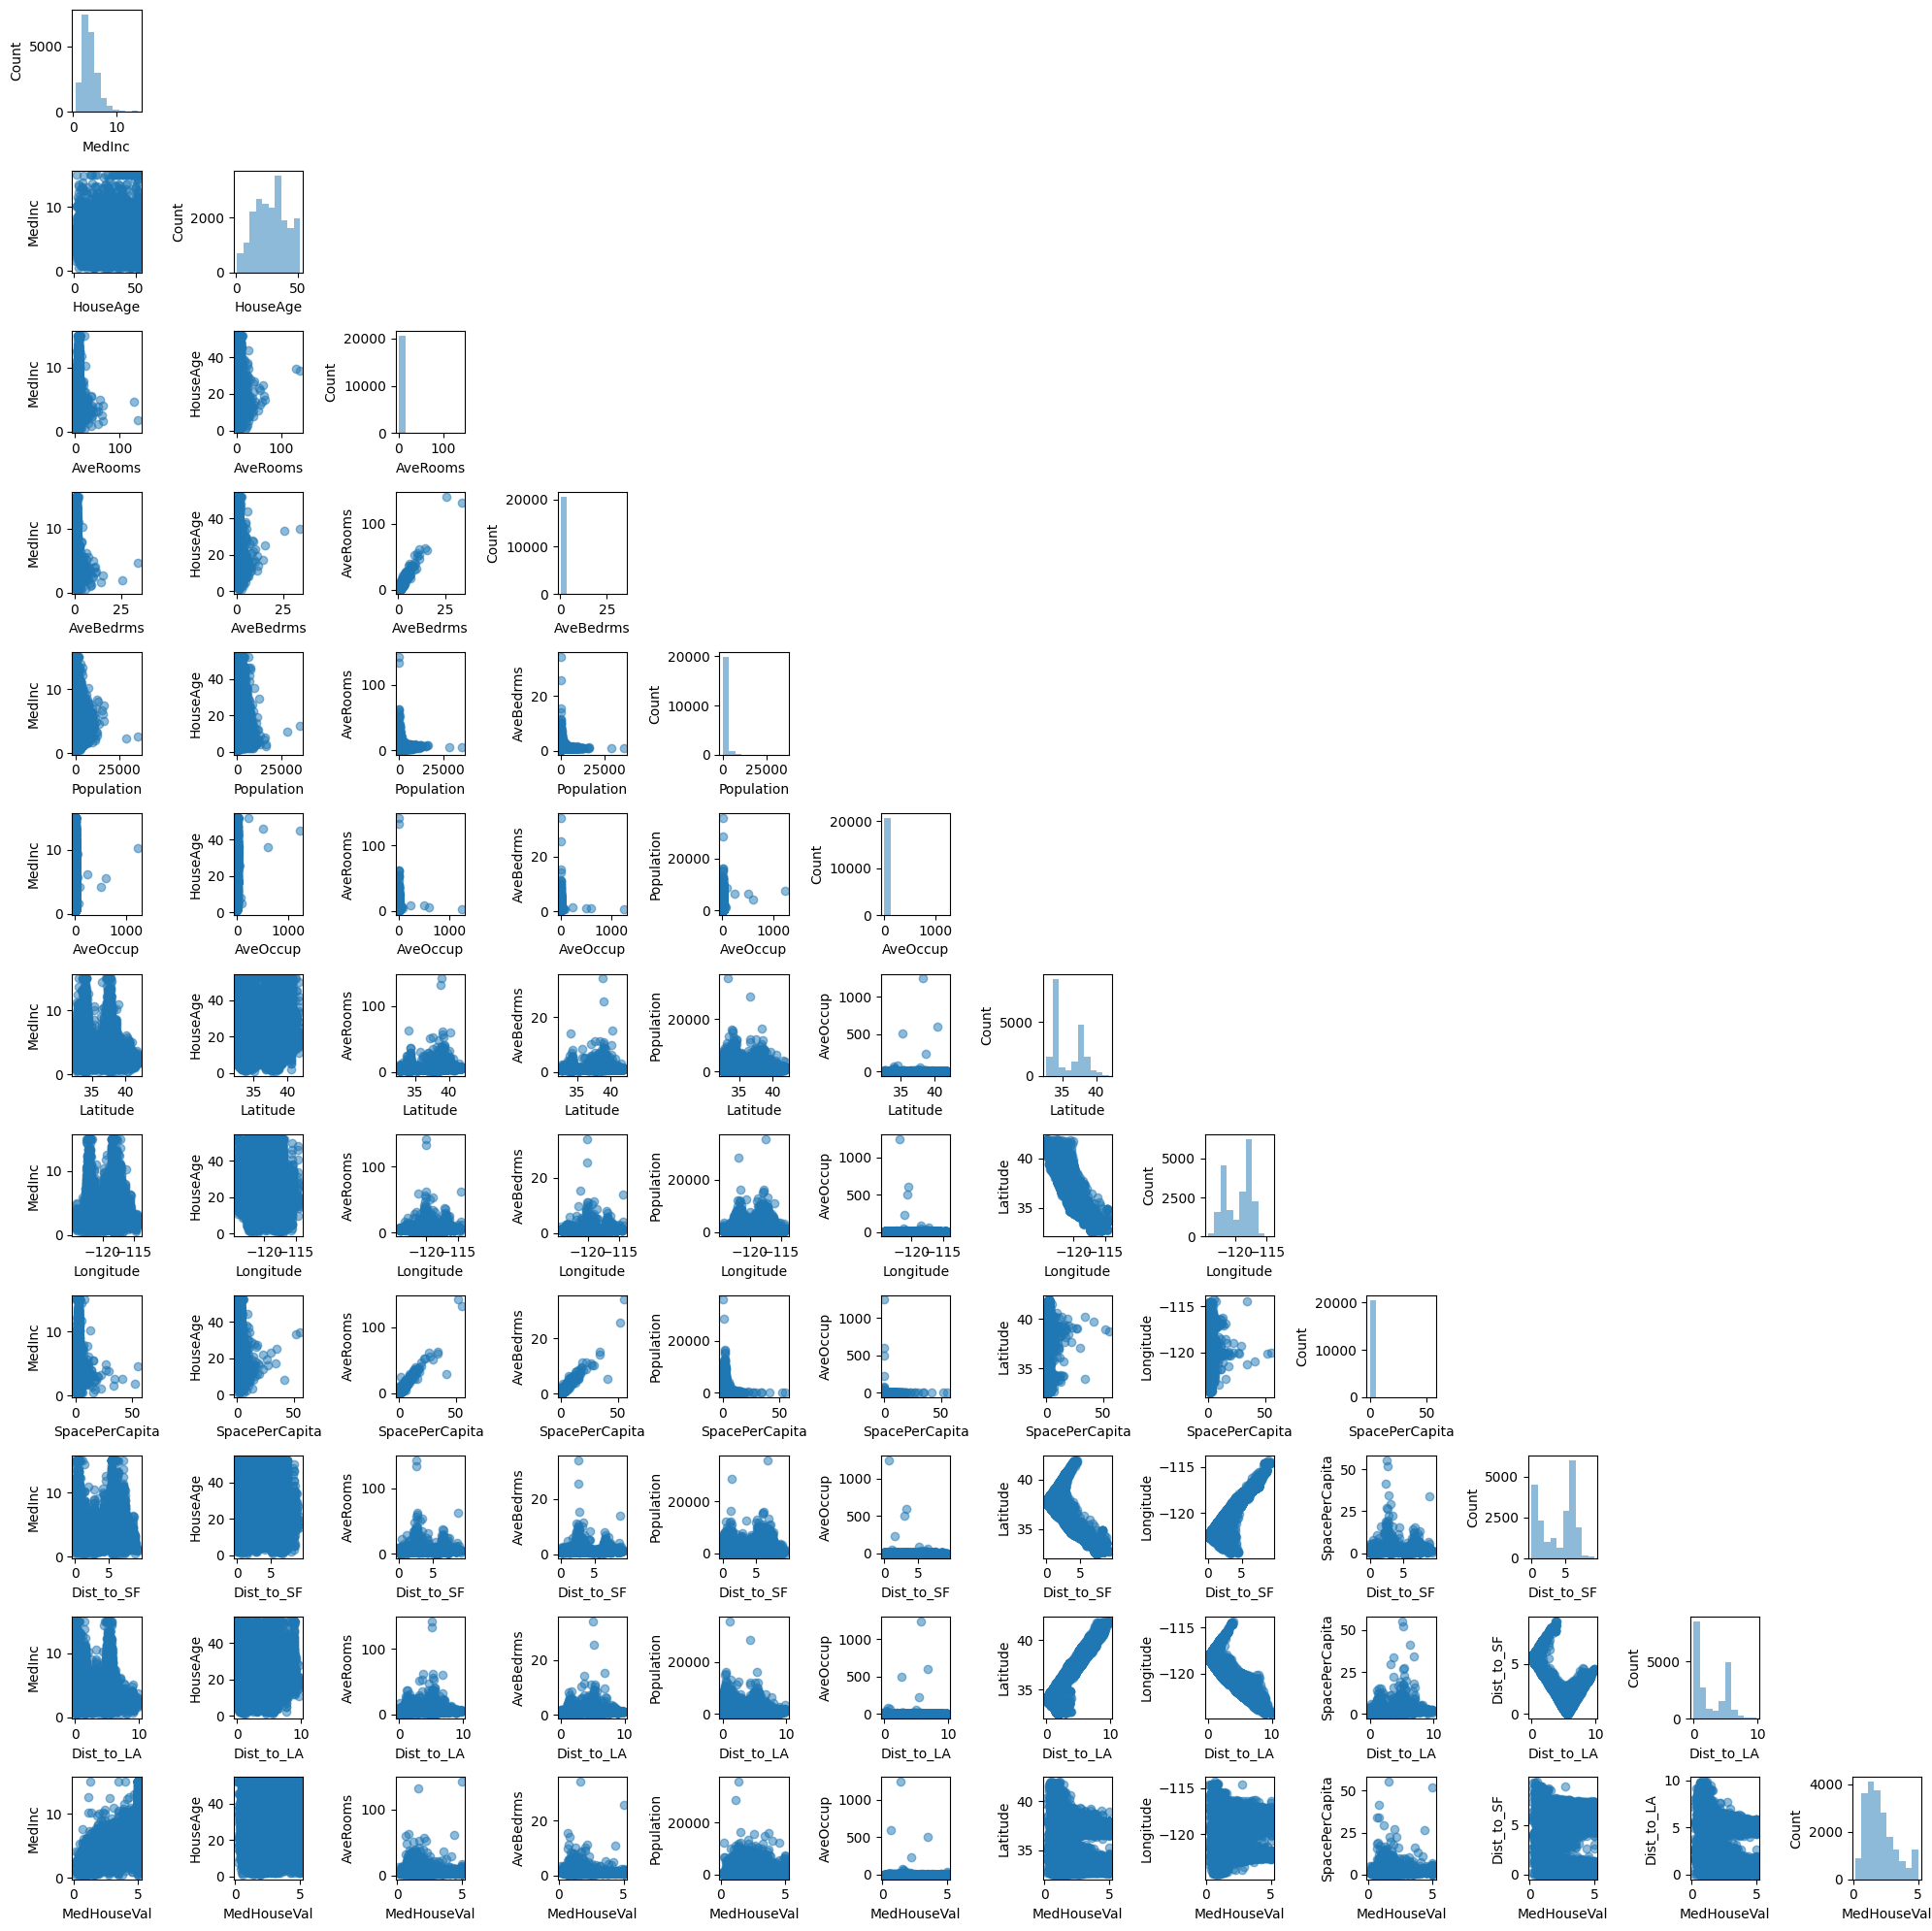

In [ ]:
#繪製散點圖矩陣(不同的成對特徵之間的關係、是否存在離群值)
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

Columns = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude',
            'SpacePerCapita', 'Dist_to_SF', 'Dist_to_LA', 'MedHouseVal']

scatterplotmatrix(df[Columns].values, figsize=(20, 20), names=Columns, alpha=0.5)
plt.tight_layout()
plt.show()
#MedInc（中位數收入）、HouseAge（中位數住房年齡）、AveRooms（平均房間數目）、AveBedrms（平均臥室數目）、Population（該區人口普查的人口數）、
#AveOccup（平均住房占用率）、Latitude（緯度）、Longitude（經度）、MedHouseVal(中位房價)
#Y 軸的 count 表示該數值區間內資料點出現的次數。

熱力圖

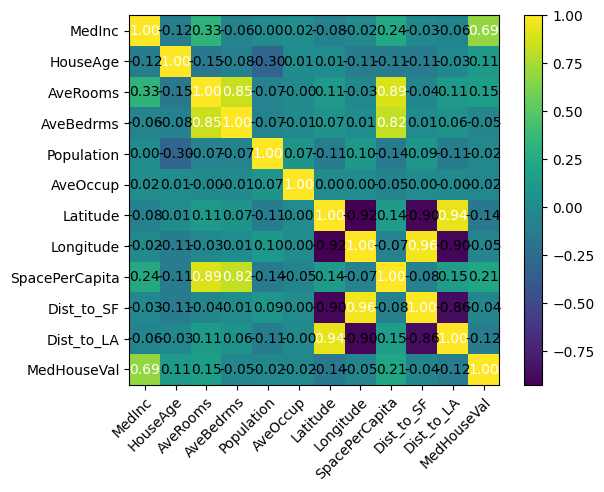

In [ ]:
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df[Columns].values.T)
hm = heatmap(cm, row_names=Columns, column_names=Columns)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X = df_filtered.drop(['Population', 'MedHouseVal', 'AveBedrms'], axis=1)
y = df_filtered['MedHouseVal']

print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude',
       'SpacePerCapita', 'Dist_to_SF', 'Dist_to_LA'],
      dtype='object')


隨機森林模型訓練和泛化能力

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=42, n_jobs=-1, max_depth=15, min_samples_leaf=10)
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"rmse(train):{rmse_train:.4f}")
print(f"rmse(test):{rmse_test:.4f}")
print(f"r2(train):{r2_score(y_train, y_train_pred)}")
print(f"r2(test):{r2_score(y_test, y_test_pred)}")

rmse(train):0.3664
rmse(test):0.4633
r2(train):0.8543133880232849
r2(test):0.7699727012103258


殘缺圖

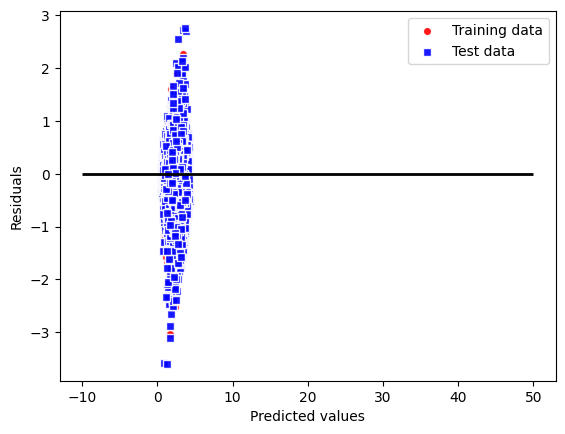

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_train_pred, y_train_pred - y_train, color='red', edgecolor='white', marker='o', alpha=0.9, label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, color='blue', edgecolors='white', marker='s', alpha=0.9, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.show()

預測值 vs. 真實值散佈圖

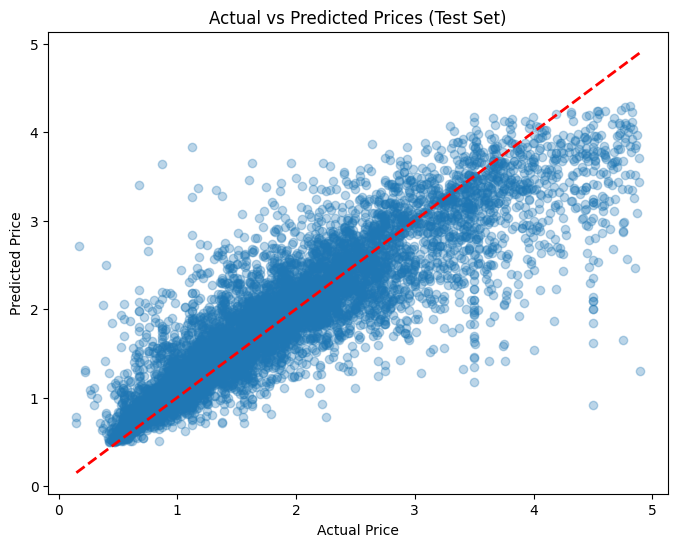

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Test Set)')
plt.show()